# Tabular Playground Series -- February 2022

## Import Training Data

In [1]:
import time
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder, FunctionTransformer
from xgboost import XGBClassifier

seed = 3165
bacteria_data = pd.read_csv('data/train.csv', index_col='row_id')
bacteria_test_data = pd.read_csv('data/test.csv', index_col='row_id')

/Users/robinonsay/Kaggle/TPSFeb22/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


## Exploratory Data Analysis (EDA)

In [2]:
bacteria_data.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0,target
row_id,,,,,,,,,,,,,,,,,,,,,
0,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Streptococcus_pyogenes
1,-9.536743e-07,-0.000010,-0.000043,0.000886,-0.000200,0.000760,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,0.000914,0.000914,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Salmonella_enterica
2,-9.536743e-07,-0.000002,0.000007,0.000129,0.000268,0.000270,0.000243,0.000125,0.000001,-0.000007,...,0.000084,0.000048,0.000081,0.000106,0.000072,0.000010,0.000008,0.000019,1.046326e-06,Salmonella_enterica
3,4.632568e-08,-0.000006,0.000012,0.000245,0.000492,0.000522,0.000396,0.000197,-0.000003,-0.000007,...,0.000151,0.000100,0.000180,0.000202,0.000153,0.000021,0.000015,0.000046,-9.536743e-07,Salmonella_enterica
4,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-0.000010,-0.000010,-9.536743e-07,Enterococcus_hirae


In [3]:
bacteria_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200000 entries, 0 to 199999
Columns: 287 entries, A0T0G0C10 to target
dtypes: float64(286), object(1)
memory usage: 439.5+ MB


In [4]:
bacteria_data.describe()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
count,2.000000e+05,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,...,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,200000.000000,2.000000e+05,2.000000e+05,2.000000e+05
mean,6.421457e-07,-0.000003,-0.000014,-0.000010,0.000005,0.000025,0.000014,-0.000009,-0.000028,-0.000008,...,0.000135,0.000348,0.000253,0.000464,0.000581,0.000379,0.000062,8.982134e-05,1.170014e-04,2.215407e-07
std,8.654927e-05,0.000132,0.000287,0.000436,0.000683,0.000869,0.000775,0.000441,0.000107,0.000083,...,0.000711,0.001117,0.000914,0.001238,0.001528,0.001182,0.000466,5.475606e-04,6.788277e-04,2.050081e-05
min,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
25%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000240,-0.000200,-0.000114,-0.000043,-0.000010,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.000010,-9.536743e-06,-9.536743e-06,-9.536743e-07
50%,-9.536743e-07,-0.000010,-0.000043,-0.000114,-0.000200,-0.000237,-0.000199,-0.000114,-0.000043,-0.000010,...,0.000014,0.000064,0.000047,0.000124,0.000114,0.000043,-0.000010,4.632568e-07,4.632568e-07,-9.536743e-07
75%,-9.536743e-07,-0.000003,-0.000013,-0.000004,-0.000011,0.000003,-0.000030,0.000004,-0.000028,-0.000010,...,0.000111,0.000463,0.000297,0.000684,0.000774,0.000365,0.000030,6.046326e-05,6.946326e-05,-9.536743e-07
max,9.999046e-03,0.009990,0.009957,0.009886,0.019800,0.019760,0.019800,0.009886,0.009957,0.009990,...,0.019957,0.019914,0.019957,0.019914,0.019914,0.019957,0.009990,9.990463e-03,1.999046e-02,9.990463e-04


### Plot Count of Target

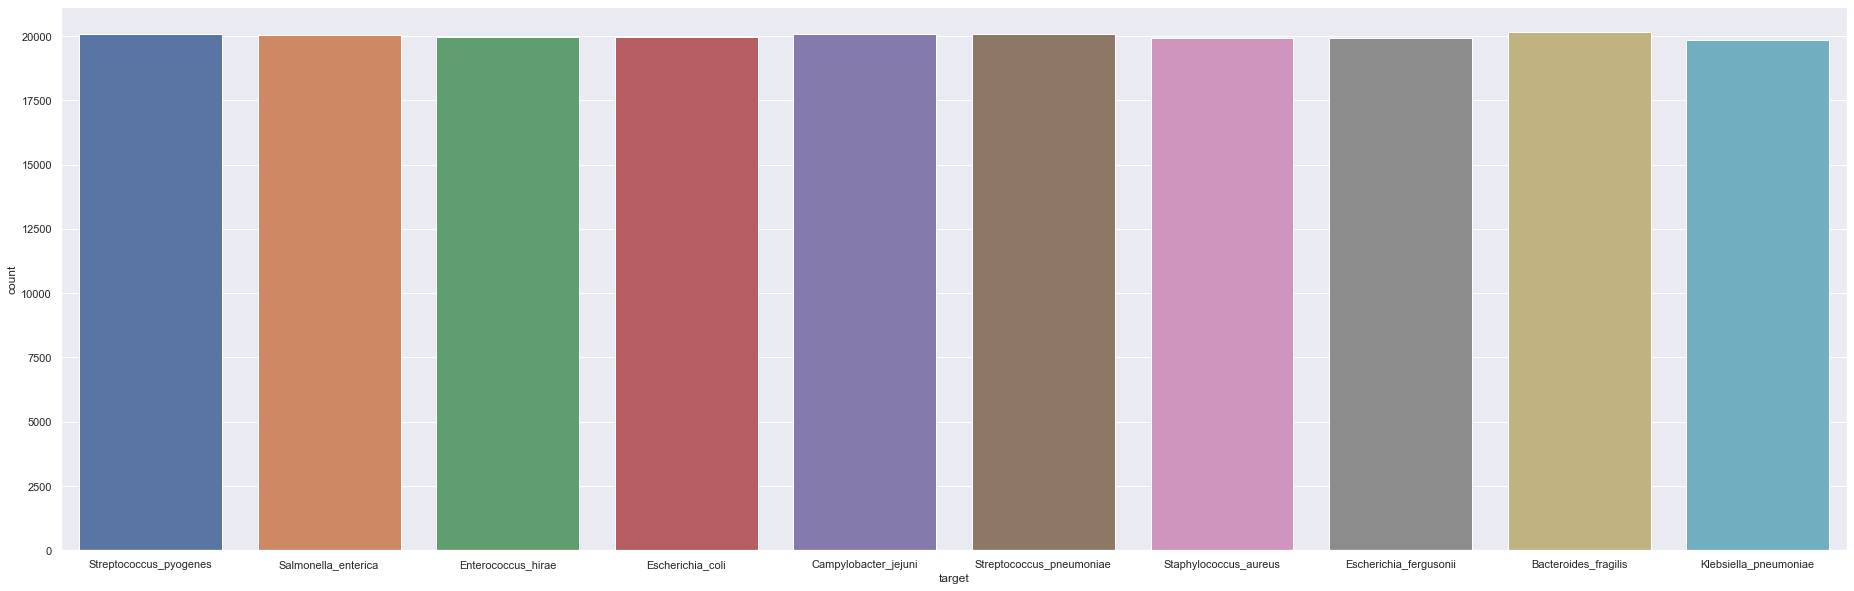

In [5]:
sns.set(rc={"figure.figsize": (32, 10)})
sns.countplot(x='target', data=bacteria_data);

### Count Missing Values

In [6]:
print(f'Training Data: {bacteria_data.isna().any().sum()}')
print(f'Test Data: {bacteria_test_data.isna().any().sum()}')

Training Data: 0
Test Data: 0


### Count Duplicate Values

In [7]:
print(f'Count Duplicates: {bacteria_data.duplicated().sum()}')

Count Duplicates: 76007


### Handle Duplicate Values
Reference: [MUHAMMAD RAAFAT's notebook](https://www.kaggle.com/adamml/classify-bacteria-species-with-acc-98-tps-feb22?scriptVersionId=87881721&cellId=16)

In [8]:
vc = bacteria_data.value_counts()
bd_no_dups = pd.DataFrame([list(row) for row in vc.index.values], columns=bacteria_data.columns)
sample_weight = vc.values

In [9]:
le = LabelEncoder()
X = bd_no_dups.drop(columns='target')
y = le.fit_transform(bd_no_dups.target)
X.head()

,A0T0G0C10,A0T0G1C9,A0T0G2C8,A0T0G3C7,A0T0G4C6,A0T0G5C5,A0T0G6C4,A0T0G7C3,A0T0G8C2,A0T0G9C1,...,A8T0G0C2,A8T0G1C1,A8T0G2C0,A8T1G0C1,A8T1G1C0,A8T2G0C0,A9T0G0C1,A9T0G1C0,A9T1G0C0,A10T0G0C0
0,-9.536743e-07,-0.00001,-0.000043,-0.000114,-0.0002,-0.00024,-0.0002,-0.000114,-0.000043,-0.00001,...,-0.000043,-0.000086,-0.000043,-0.000086,-0.000086,-0.000043,-0.00001,-0.00001,-0.00001,-9.536743e-07
1,-9.536743e-07,-0.00001,-0.000043,0.000886,-0.0002,0.00076,-0.0002,0.000886,-0.000043,-0.00001,...,-0.000043,0.000914,-0.000043,-0.000086,-0.000086,-0.000043,-0.00001,-0.00001,0.00099,-9.536743e-07
2,-9.536743e-07,-0.00001,-0.000043,-0.000114,-0.0002,-0.00024,-0.0002,-0.000114,-0.000043,-0.00001,...,-0.000043,-0.000086,-0.000043,-0.000086,0.000914,0.002957,-0.00001,-0.00001,-0.00001,-9.536743e-07
3,-9.536743e-07,-0.00001,-0.000043,-0.000114,-0.0002,-0.00024,-0.0002,-0.000114,-0.000043,-0.00001,...,-0.000043,-0.000086,-0.000043,-0.000086,0.009914,-0.000043,-0.00001,-0.00001,-0.00001,-9.536743e-07
4,-9.536743e-07,-0.00001,-0.000043,-0.000114,-0.0002,-0.00024,-0.0002,-0.000114,-0.000043,-0.00001,...,-0.000043,0.000914,0.000957,0.001914,0.000914,-0.000043,-0.00001,-0.00001,-0.00001,-9.536743e-07


In [10]:
X_train, X_test, y_train, y_test, sample_weight_train, _ = train_test_split(X, y,
                                                                            sample_weight, stratify=y,
                                                                            random_state=seed)

## Custom Transform

In [11]:
def binned_scaler_transform(X, y=None, *args, **kwargs):
    MAX = np.max(np.abs(np.array(X)))
    return X / MAX

## Find Best Model

In [12]:
params = {
    'use_label_encoder': False,
    'random_state': seed,
    'tree_method': 'gpu_hist',
}
xgb_model = XGBClassifier(**params)
pipe = Pipeline([
    ('scaler', FunctionTransformer(func=binned_scaler_transform)),
    ('feature_selection', SelectKBest()),
    ('model', xgb_model)
])

In [13]:
param_grid = {
    'feature_selection__k': [1, 6, 12, 25, 50, 100],
    'model__n_estimators': [4000, 5000, 6000],
    'model__max_depth': [6],
    'model__learning_rate': [0.01, 0.1],
    'model__subsample': [0.4, 0.5, 0.6, 1],
}
fit_params = {
    'model__sample_weight': sample_weight_train,
    'model__eval_metric': 'mlogloss',
}
grid = GridSearchCV(pipe, param_grid=param_grid,
                    scoring='accuracy', n_jobs=-1,
                    cv=5, verbose=2, refit=True)
t0 = time.perf_counter_ns()
grid.fit(X_train, y_train, **fit_params)
print(f'Fit time (minutes): {((time.perf_counter_ns() - t0) * 1e-9 / 60):.2f}')

Fitting 5 folds for each of 96 candidates, totalling 480 fits


/Users/robinonsay/Kaggle/TPSFeb22/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/robinonsay/Kaggle/TPSFeb22/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/robinonsay/Kaggle/TPSFeb22/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/Users/robinonsay/Kaggle/TPSFeb22/venv/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and wi

KeyboardInterrupt: 

In [ ]:
print(f'Mean Fit Time: {grid.cv_results_['mean_fit_time']}')
print(f'Best Params:\n{grid.best_params_}')
print(f'Best Score: {grid.best_score_}')
print(f'Train Score: {grid.score(X_train, y_train)}')
print(f'Test Score: {grid.score(X_test, y_test)}')

## Train on Complete Dataset and Predict Test Values

In [ ]:
best_xgbm = grid.best_estimator_
best_fit_params = {
    'model__sample_weight': sample_weight,
    'model__eval_metric': 'mlogloss',
}
best_xgbm.fit(X,y, **best_fit_params)

In [ ]:
bacteria_test_data['target'] = le.inverse_transform(best_xgbm.predict(bacteria_test_data))
bacteria_test_data['target'].to_csv(f'./submission.csv')